# Hypothesis Testing Simulation

### Objective: Simulate A/B testing to understand the effects of different variables on user engagement. 

### Importing Libraries

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2, ttest_ind, t
import random

### Data Generation

We are going to generate a user engagment data for 2 webpage designs with the following parameters:
- Click Through Rate (CTR) - between 0 and 100
- Time Spent (sec) - between 0 and 60
- Conversion

In [47]:
# A function to generate engagement dataset for both webpages
def generate_webpage_data(webpage: str, num_users: int, distribution: dict):
    """
    Generate website user engagement datasets

    Parameters:
        webpage: The webpage to generate data for.
        num_users: The number of users to generate data for.
        distribution: The distribution to generate data from.

    Returns:
        dict: A dictionary containing the engagement data.
    """

    # Set the seed 
    random.seed(42)

    # Check if the webpage is a string
    if (type(webpage) != str):
        raise TypeError('Webpage must be a string')

    # Check if the number of users is an integer
    if (type(num_users) != int):
        raise TypeError('Number of users must be an integer')
    
    # Check if the distribution is a dictionary
    if (type(distribution) != dict):
        raise TypeError('Distribution must be a dictionary')
    
    # Check if the distribution contains the required keys
    keys = ['ctr', 'time', 'converted']
    if not all(key in distribution.keys() for key in keys):
        raise KeyError('Distribution must contain the keys: ctr, time, converted')
    
    # Check if the distribution contains the required values
    if not all(isinstance(value, (int, float)) for value in distribution.values()):
        raise ValueError('Distribution must contain the values: int or float')
    
    # Generate engagement data
    ctr = np.random.binomial(1, distribution['ctr'], num_users)
    time = np.random.normal(30, distribution['time'], num_users)
    converted = np.random.binomial(1, distribution['converted'], num_users)

    # Return the engagement data
    return {
        'Webpage': [webpage] * num_users,
        'Click Through Rate': ctr,
        'Time Spent (sec)': time,
        'Conversion': converted
    }

In [48]:
# A function to generate engagement dataset for both webpages
def generate_engagement_data(num_users: int, as_csv: str = 'engagment_data'):
    """
    Generate engagement dataset for both webpages
    Then stores the data in a csv file

    Parameters:
        num_users: The number of users to generate data for.
        as_csv: The name for the CSV file.
    """

    # Check if the number of users is an integer
    if (type(num_users) != int):
        raise TypeError('Number of users must be an integer')

    # Generate engagement data for Webpage A
    webpage_a_data = generate_webpage_data(num_users=num_users, webpage='Webpage A', distribution={
        'ctr': 0.259,
        'time': 21,
        'converted': 0.345
    })

    # Generate engagement data for Webpage B
    webpage_b_data = generate_webpage_data(num_users=num_users, webpage='Webpage B', distribution={
        'ctr': 0.299,
        'time': 24,
        'converted': 0.278
    })

    # Concatenate the webpages data into a single DataFrame
    data_a = pd.DataFrame(webpage_a_data)
    data_b = pd.DataFrame(webpage_b_data)
    engagement_df = pd.concat([data_a, data_b], axis=0).sample(frac=1).reset_index(drop=True)

    engagement_df.to_csv(f'{as_csv}.csv', index=False)

Generate and store the engagement data

In [49]:
# Set number of users
num_users = 1000

# Generate and store the engagement data
generate_engagement_data(num_users=num_users)

### Hypothesis Testing

##### Define the context of the A|B Testing

In this test, we want to determine if there is a statistically significant difference between the two webpage designs `Webpage A` and `Webpage B`.

##### Define Groups

`Group A`: The control group - Webpage A

`Group B`: The treatment group - Webpage B


##### Define the case studies

`Case study`: Webpage A - This is the original design of the webpage.

`Case study`: Webpage B - This is the new design of the webpage.

##### Metric

The outcome we want to measure are the` Click Through rate`, `Time Spent` and `Conversion` of the users on the webpages to know which webpage is more effective.

In [50]:
# Read the engagement data
def read_dataset(path='./engagment_data.csv'):
    """
    Read the dataset generated above

    Parameters:
        path: The path to the dataset.

    Returns:
        pd.DataFrame: The engagement dataset.
    """
    
    # Make sure file exists
    try:
        # Get the engagement dataset
        df = pd.read_csv(path)
    except FileNotFoundError:
        print('File not found, Please make sure the file exist and try again')

    # Check if the dataframe is empty
    if (df.empty):
        raise ValueError('Engagement data is empty')
    
    # Check if the dataframe has the required columns
    if (df.columns.tolist().count('Conversion') != 1):
        raise ValueError('Conversion column not found')
    
    return df

In [51]:
# Read the dataset
df = read_dataset()

In [73]:
def difference_in_means(column: str):
    """
    Determine if there is a difference in the mean of the specified column between the two webpages

    Parameters:
        column: The column to compare.

    Returns:
        tuple: The t-statistic and p-value.
    """

    # Check if the column is numerical
    if (df[column].dtype != 'float64'):
        raise TypeError('Column must be numerical')

    # Is there a difference in the mean of the specified column between the two webpages given that it is numerical
    # Perform the t-test to check which of the websites has more time spent
    # Will use ttest_ind because Time Spent (sec) is a numerical data

    # Extract Time Spent (sec) from the Dataframe
    webpage_a = df[df['Webpage'] == 'Webpage A'][column]
    webpage_b = df[df['Webpage'] == 'Webpage B'][column]

    # Run Chi2_contingency using the click_contingency_table
    return ttest_ind(webpage_a, webpage_b)

In [76]:
# Test the conversion
def difference_in_frequency(column: str):
    """
    Determine if there is a difference in the frequency of the specified column between the two webpages

    Parameters:
        column: The column to compare, it must be a categorical dataset.

    Returns:
        tuple: The chi-square statistic, p-value, dof, expected frequency.
    """

    # Check if the column exists in dataframe
    if (df.columns.to_list().count(column) == 0):
        raise TypeError('Column does not exist in dataframe')

    # Is there a difference in the frequency of the specified column between the two webpages given that it is categorical
    # Perform the chi-square test to check which of the websites has more clicks
    # Will use Chi2_contingency because Click Through Rate (CTR) is a categorical data of (Clicked(1) and Not_Clicked(0))

    # Get the contingency table for click through rate which is the frequency of (Clicked(1) and Not_Clicked(0)) of both webpages
    contingency_table = pd.crosstab(df['Webpage'], df[column])
    
    # Run Chi2_contingency using the contingency_table
    return chi2_contingency(contingency_table)    

In [54]:
def mean_difference_confidence_interval(column: str, confidence_level: float):
    """
    Calculate the confidence interval for a difference using the chi-square critical values.

    Parameters:
        diff (float): The difference or observed statistic.
        dof (int): Degrees of freedom for the chi-square test (default = 1).
        confidence_level (float): Desired confidence level (default = 0.95).

    Returns:
        tuple: Lower and upper bounds of the confidence interval.
    """
    
    # Get the datasets
    webpage_a = df[df['Webpage'] == 'Webpage A'][column]
    webpage_b = df[df['Webpage'] == 'Webpage B'][column]

    # Sample Statistics
    n_a, n_b = len(webpage_a), len(webpage_b)
    mean_a, mean_b = np.mean(webpage_a), np.mean(webpage_b)
    var_a, var_b = np.var(webpage_a, ddof=1), np.var(webpage_b, ddof=1)

    # Pooled standard deviation (since variances are assumed equal)
    pooled_std = np.sqrt(((n_a - 1) * var_a + (n_b - 1) * var_b) / (n_a + n_b - 2))

    # Standard error of the difference in means
    se_diff = pooled_std * np.sqrt(1 / n_a + 1 / n_b)

    # Degrees of freedom (n_a + n_b - 2 for equal variance t-test)
    dof = n_a + n_b - 2

    # Critical t-value
    alpha = 1 - confidence_level
    t_critical = t.ppf(1 - alpha / 2, dof)

    # Margin of error
    margin_of_error = t_critical * se_diff

    # Confidence interval for the difference in means
    mean_diff = mean_a - mean_b
    lower_bound = mean_diff - margin_of_error
    upper_bound = mean_diff + margin_of_error

    return lower_bound, upper_bound

In [55]:
def chi2_confidence_interval(diff: float, dof: int, confidence_level: float):
    """
    Calculate the confidence interval for a difference using the chi-square critical values.

    Parameters:
        diff (float): The difference or observed statistic.
        dof (int): Degrees of freedom for the chi-square test (default = 1).
        confidence_level (float): Desired confidence level (default = 0.95).

    Returns:
        tuple: Lower and upper bounds of the confidence interval.
    """

    # Calculate the critical value
    alpha = 1 - confidence_level

    # Chi-square critical values for the lower and upper tails to account for the a
    chi2_lower = chi2.ppf(alpha / 2, dof)
    chi2_upper = chi2.ppf(1 - alpha / 2, dof)

    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = diff - chi2_lower
    upper_bound = diff + chi2_upper

    return lower_bound, upper_bound

In [56]:
# Check for statistical significance on clicks only.
def test_click_through(webpage_a, webpage_b, confidence_level=0.95):
    """
    Test for difference between webpages based on their Click Through Rates

    Parameters:
        webpage_a: The Dataframe for webpage a
        webpage_b: The Dataframe for webpage b
        confidence_level (float): Desired confidence level (default = 0.95).
    """

    if (type(webpage_a) != pd.DataFrame):
        raise Exception('Webpage A must be a Pandas Dataframe')
    
    if (type(webpage_b) != pd.DataFrame):
        raise Exception('Webpage B must be a Pandas Dataframe')

    if (type(confidence_level) != float):
        raise Exception('Confidence Level must be a float')

    # To do this we need to calculate the frequencies of the Click Through Rate dataset
    # Given that it is a categorical dataset of (1, 0), we will run a chi2 test to know if there is a significant difference in the frequencies of both datasets.
    print('Testing Click Through Rate')

    # State the Hypothesis
    null_hypothesis = 'There is no significant difference in the frequencies of the Click Through Rate of both Webpages'
    alternative_hypothesis = 'There is a significant difference in the frequencies of the Click Through Rate of both Webpages'
    print(f'Null Hypothesis: {null_hypothesis}')
    print(f'Alternative Hypothesis: {alternative_hypothesis}')

    # set threshold to Reject P-Value
    threshold = 0.05

    # Check the rate of Click Through in both webpages
    a_percent = (webpage_a['Click Through Rate'].sum()/len(webpage_a)) * 100
    b_percent = (webpage_b['Click Through Rate'].sum()/len(webpage_b)) * 100
    print(f'Webpage A percentage Click Through Rate: {a_percent}%')
    print(f'Webpage B percentage Click Through Rate: {b_percent}%')

    # Calculate the chi_2_stats, p_value, degree of freedom
    chi2_stat, p_value, dof, _ =  difference_in_frequency(column='Click Through Rate')
    print(f'Base on the above test; the difference in the frequencies of Clicks in Webpage A and Webpage B is chi2_stat = {chi2_stat}')
    print(f'The probability of this difference occuring is the p_value = {p_value}')

    if p_value < threshold:
        print(f'P-value < {threshold}: We reject the Null Hypothesis and accept that {alternative_hypothesis}')
    else:
        print(f'P-value >= {threshold}: We accept the Null Hypothesis that {null_hypothesis}')

    # Calculate the Confidence interval for the above statistics with a confidence level of 0.95
    ci = chi2_confidence_interval(diff=chi2_stat, dof=dof, confidence_level=confidence_level)
    print(f'With a {confidence_level * 100}% confidence level, we can say that the difference between the frequencies of the Click Through Rate of both webpages lies around {ci[0]} to {ci[1]}')


In [57]:
# Test statistical significance on Time spent on the webpage
def test_time_spent(webpage_a, webpage_b, confidence_level=0.95):
    """
    Test for difference between webpages based on the time spent on the webpage

    Parameters:
        webpage_a: The Dataframe for webpage a
        webpage_b: The Dataframe for webpage b
        confidence_level (float): Desired confidence level (default = 0.95).
    """

    if (type(webpage_a) != pd.DataFrame):
        raise Exception('Webpage A must be a Pandas Dataframe')
    
    if (type(webpage_b) != pd.DataFrame):
        raise Exception('Webpage B must be a Pandas Dataframe')

    if (type(confidence_level) != float):
        raise Exception('Confidence Level must be a float')
    
    # To do this we need to calculate the difference in mean of the 2 datasets using a ttest
    print('Testing Time Spent')
    
    # State the Hypothesis
    null_hypothesis = 'There is no significant difference in the mean of the Time Spent on both Webpages'
    alternative_hypothesis = 'There is a significant difference in the mean of the Time Spent on both Webpages'
    print(f'Null Hypothesis: {null_hypothesis}')
    print(f'Alternative Hypothesis: {alternative_hypothesis}')

    # set threshold to Reject P-Value
    threshold = 0.05

    # Check the mean of Time spent on each webpage
    a_mean = webpage_a['Time Spent (sec)'].mean()
    b_mean = webpage_b['Time Spent (sec)'].mean()
    print(f'Webpage A average Time Spent mean: {a_mean}')
    print(f'Webpage B average Time Spent mean: {b_mean}')

    t_stat, p_value = difference_in_means(column='Time Spent (sec)')
    print(f'Base on the above test; the difference in the frequencies of Conversion in Webpage A and Webpage B is t_stat = {t_stat}')
    print(f'The probability of this difference occuring is the p_value = {p_value}')

    if p_value < threshold:
        print(f'P-value < {threshold}: We reject the Null Hypothesis and accept that {alternative_hypothesis}')
    else:
        print(f'P-value >= {threshold}: We accept the Null Hypothesis that {null_hypothesis}')

    ci = mean_difference_confidence_interval('Time Spent (sec)', confidence_level=confidence_level)
    print(f'With a {confidence_level * 100}% confidence level, we can say that the difference between the mean of the Time Spent on both webpages lies around {ci[0]} to {ci[1]}')


In [58]:
# Test statistical significance on conversion only.
def test_conversions(webpage_a, webpage_b, confidence_level=0.95):
    """
    Test for difference between webpages based on their Conversion Rate
    
    Parameters:
        webpage_a: The Dataframe for webpage a
        webpage_b: The Dataframe for webpage b
        confidence_level (float): Desired confidence level (default = 0.95).
    """

    if (type(webpage_a) != pd.DataFrame):
        raise Exception('Webpage A must be a Pandas Dataframe')
    
    if (type(webpage_b) != pd.DataFrame):
        raise Exception('Webpage B must be a Pandas Dataframe')

    if (type(confidence_level) != float):
        raise Exception('Confidence Level must be a float')
    
    # To do this we need to calculate the frequencies of the Conversion dataset
    # Given that it is a categorical dataset of (1, 0), we will run a chi2 test to know if there is a significant difference in the frequencies of both datasets.
    print('Testing Conversion')
    
    # State the Hypothesis
    null_hypothesis = 'There is no significant difference in the frequencies of the Conversion Rate of both Webpages'
    alternative_hypothesis = 'There is a significant difference in the frequencies of the Conversion Rate of both Webpages'
    print(f'Null Hypothesis: {null_hypothesis}')
    print(f'Alternative Hypothesis: {alternative_hypothesis}')

    # set threshold to Reject P-Value
    threshold = 0.05

    # Check the rate of Conversion in both webpages
    a_conv_percent = (webpage_a['Conversion'].sum()/len(webpage_a)) * 100
    b_conv_percent = (webpage_b['Conversion'].sum()/len(webpage_b)) * 100
    print(f'Webpage A percentage Conversion: {a_conv_percent}%')
    print(f'Webpage B percentage Conversion: {b_conv_percent}%')

    # Calculate the chi_2_stats, p_value, degree of freedom
    chi2_stat, p_value, dof, _ =  difference_in_frequency(column='Conversion')
    print(f'Base on the above test; the difference in the frequencies of Conversions in Webpage A and Webpage B is chi2_stat = {chi2_stat}')
    print(f'The probability of this difference occuring is the p_value = {p_value}')
    
    if p_value < threshold:
            print(f'P-value < {threshold}: We reject the Null Hypothesis and accept that {alternative_hypothesis}')
    else:
        print(f'P-value >= {threshold}: We accept the Null Hypothesis that {alternative_hypothesis}')

    # Calculate the Confidence interval for the above statistics with a confidence level of 0.95
    ci = chi2_confidence_interval(diff=chi2_stat, dof=dof, confidence_level=0.95)
    print(f'With a {confidence_level * 100}% confidence level, we can say that the difference between the frequencies of the Conversion of both webpages lies around {ci[0]} to {ci[1]}')


In [71]:
# Run Hypothesis test to check which webpage is better based on the 3 columns of the engagment dataset.
def run_tests():
    # Group dataframe by webpage
    webpage_group = df.groupby('Webpage')

    # Get the different webpages
    webpage_a = webpage_group.get_group('Webpage A')
    webpage_b = webpage_group.get_group('Webpage B')
    confidence_level = 0.95

    # The for difference in the frequencies of the Click Through Rates of both webpages
    test_click_through(webpage_a, webpage_b, confidence_level)
    print('\n')

    # The for difference in the mean of the Time Spent of both webpages
    test_time_spent(webpage_a, webpage_b, confidence_level)
    print('\n')

    # The for difference in the frequencies of the Conversion of both webpages
    test_conversions(webpage_a, webpage_b, confidence_level)
    print('\n')

Testing Click Through Rate
Null Hypothesis: There is no significant difference in the frequencies of the Click Through Rate of both Webpages
Alternative Hypothesis: There is a significant difference in the frequencies of the Click Through Rate of both Webpages
Webpage A percentage Click Through Rate: 23.599999999999998%
Webpage B percentage Click Through Rate: 31.3%
Base on the above test; the difference in the frequencies of Clicks in Webpage A and Webpage B is chi2_stat = 14.501650140158349
The probability of this difference occuring is the p_value = 0.0001400368212012249
P-value < 0.05: We reject the Null Hypothesis and accept that There is a significant difference in the frequencies of the Click Through Rate of both Webpages
With a 95.0% confidence level, we can say that the difference between the frequencies of the Click Through Rate of both webpages lies around 14.500668071041174 to 19.525536327473237


Testing Time Spent
Null Hypothesis: There is no significant difference in the

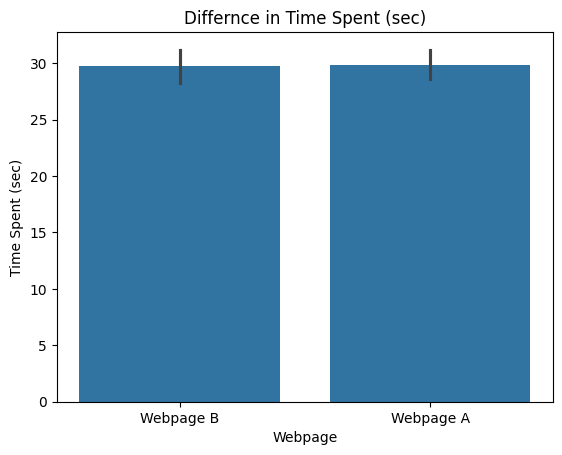

In [77]:
run_tests()